# A demo of Self-Supervised Learning (SSL)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import os.path as osp
import warnings
from copy import deepcopy
from typing import List, Union

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from pygod.metrics import (eval_average_precision, eval_precision_at_k,
                           eval_recall_at_k, eval_roc_auc)
from scipy.special import erf
from scipy.stats import binom
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils.validation import check_is_fitted
from torch_geometric.data import Data, HeteroData
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn.models import GraphSAGE
from torch_geometric.transforms import BaseTransform
from torch_geometric.utils import to_dense_adj
import random

import glob
import os
import os.path as osp

import networkx as nx
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch_geometric.data import Batch, Data, InMemoryDataset

from psd_gnn.utils import create_dir, parse_adj
from psd_gnn.dataset import PSD_Dataset


In [3]:
def sample_gumbel(shape, eps=1e-20):
    unif = torch.rand(*shape)
    g = -torch.log(-torch.log(unif + eps))
    return g 

def sample_gumbel_softmax(logits, temperature):
    """
        Input:
        logits: Tensor of log probs, shape = BS x k
        temperature = scalar
        
        Output: Tensor of values sampled from Gumbel softmax.
                These will tend towards a one-hot representation in the limit of temp -> 0
                shape = BS x k
    """
    g = sample_gumbel(logits.shape)
    h = (g + logits)/temperature
    h_max = h.max(dim=-1, keepdim=True)[0]
    h = h - h_max
    cache = torch.exp(h)
    y = cache / cache.sum(dim=-1, keepdim=True)
    return y

In [4]:
""" utility functions and classes """
def validate_device(gpu):
    """ Validate GPU device. """
    gpu_id = int(gpu)
    if gpu_id >= 0 and torch.cuda.is_available() and torch.cuda.device_count() > gpu_id:
        device = torch.device(f'cuda:{gpu_id}')
    else:
        device = torch.device('cpu')
    return device

class MinMaxNormalizeFeatures(BaseTransform):
    r"""Min-max normalizes the attributes given in :obj:`attrs` to scale between 0 and 1.
    (functional name: :obj:`minmax_normalize_features`).
    Args:
        attrs (List[str], optional): The names of attributes to normalize. Defaults to ["x"].
    """

    def __init__(self, attrs: List[str] = ["x"],
                 min: int = 0,
                 max: int = 1) -> None:
        self.attrs = attrs
        self.min = min
        self.max = max

    def __call__(
        self,
        data: Union[Data, HeteroData],
    ) -> Union[Data, HeteroData]:
        for store in data.stores:
            for key, value in store.items(*self.attrs):
                # add a small eps for nan values
                value = value.sub(value.min(dim=0)[0]).div(value.max(dim=0)[0].sub(
                    value.min(dim=0)[0] + 1e-10))
                value = value * (self.max - self.min) + self.min
                store[key] = value
        return data

In [5]:
# SSL and SSL_base classes
class SSL(nn.Module):    
    def __init__(self,
                hid_dim=64,
                num_layers=4,
                dropout=0.5,
                weight_decay=0.,
                act=F.relu,
                alpha=None,
                eta=.5,
                contamination=0.05,
                lr=5e-3,
                epoch=200,
                iter__=100,
                gpu=0,
                batch_size=0,
                num_neigh=-1,
                margin=.5,
                r=.2,
                m=50,
                k=50,
                f=10,
                K=10,
                N=2,
                temperature=1,
                verbose=False):
        super(SSL, self).__init__()
        assert 0. < contamination <= 0.5, ValueError(f"contamination must be in (0, 0.5], got: {contamination:.2f}")
        
        self.contamination = contamination
        self.decision_scores_ = None
        # model param
        self.hid_dim = hid_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.weight_decay = weight_decay
        self.act = act
        self.alpha = alpha
        self.eta = eta
        self.iter__ = iter__
        # training param
        self.lr = lr
        self.epoch = epoch
        self.device = validate_device(gpu)
        self.batch_size = batch_size
        self.num_neigh = num_neigh
        self.margin_loss_func = torch.nn.MarginRankingLoss(margin=margin)

        # other param
        self.verbose = verbose
        self.r = r
        # self.m = m
        self.k = k
        self.f = f
        self.model = None
        self.N=N
        self.K=K
        self.temperature=temperature

    #  Processing uncertainty scores
    def generate_anomaly__list_(self, uncert__, y_true, **kwargs):
        """ Sample from workflows with anomaly types.

        Args:
            workflows (str | list): workflow name(s). 
            anomaly_types (str): anomaly type.
            sample_size (int, optional): sample size. Defaults to 30.

        Returns:
            dataset: InMemoryDataset.
        """
        Tot_list = ['cpu', 'hdd', 'normal']
        from psd_gnn.dataset import Merge_PSD_Dataset
        import os.path as osp
        # print("The list, I am working with ", Tot_list)
        # print("The uncertainty scores corresponding to it", uncert__)
        # print("The labels I am working with", y_true)
        min__ = np.argsort(uncert__)
        y = np.reshape(y_true.numpy()[min__], [-1])
        # print("The labels now", y)
        y__ = y[0:1]
        y__converted = [Tot_list[ele] for ele in y__]
        # print(y__, y__converted)
        return y__converted[0]


    # NOTE: update the dataset.py file in your local folder.
    def generate_anomaly_type_data(self, workflows=None, anomaly_types=None,\
                                   uncert__=None, y=None, sample_size=30, **kwargs):
        """ Sample from workflows with anomaly types.

        Args:
            workflows (str | list): workflow name(s). 
            anomaly_types (str): anomaly type.
            sample_size (int, optional): sample size. Defaults to 30.

        Returns:
            dataset: InMemoryDataset.
        """
        from psd_gnn.dataset import Merge_PSD_Dataset
        import os.path as osp
        node_level = kwargs.get("node_level", True)        
        ROOT = osp.join("/tmp", "data", "psd", "all")
        parsed_root = osp.join("/tmp", "data", "psd", "parsed")
        workflows = [workflows] if isinstance(workflows, str) else workflows
        if isinstance(anomaly_types, str):
            # print("I came here and went bonkers initially")
            self.remove_folder(parsed_root)
        
        anomaly_types  = [anomaly_types] if isinstance(anomaly_types, str) else anomaly_types
        # print("in the anomaly types data", anomaly_types, workflows)

        if uncert__ is None:
            dataset = Merge_PSD_Dataset(ROOT, name=workflows, 
                                        anomaly_cat=anomaly_types, 
                                        node_level=node_level, 
                                        binary_labels=False, 
                                        sample_size=sample_size, 
                                        force_reprocess=True)
            
            # print(dataset[0].y, max(dataset[0].y))
            return dataset
        
        else:  
            # print("with uncertainty")
            # print("The y in this loop", y)            
            new_anomaly__ = self.generate_anomaly__list_(uncert__, y)
            anomaly_types.append( str(new_anomaly__) )
            # print("this is what I came out", anomaly_types)
            workflows = [workflows] if isinstance(workflows, str) else workflows
            dataset = Merge_PSD_Dataset(ROOT, name=workflows, 
                                        anomaly_cat=anomaly_types, 
                                        node_level=node_level, 
                                        binary_labels=False, 
                                        sample_size=sample_size, 
                                        force_reprocess=True)
            # print("This is what I am sending out from uncertainty")
            return dataset, anomaly_types


    # NOTE: update the dataset.py file in your local folder.
    def remove_folder(self, folder_path):
        """Removes a folder given its path.

        Args:
            folder_path: The path to the folder to remove.

        Raises:
            OSError: If the folder cannot be removed.
        """
        import os
        import shutil
        if not os.path.exists(folder_path):
            print(f"The folder '{folder_path}' does not exist.")
            return
        elif os.path.isfile(folder_path):
            print(f"The path '{folder_path}' is a file, not a folder.")
            return
        else:
            shutil.rmtree(folder_path)


    def generate_large_graphs(self, dataset, **kwargs):
        """ Build large graphs given a list of graphs.

        Args:
            dataset (InMemoryDataset): Dataset object.
        
        Returns:
            tuple: data and slices.
        """    
        from torch_geometric.loader import DataLoader, RandomNodeLoader

        node_level = kwargs.get("node_level", True)
        batch_size = kwargs.get("batch_size", 1)
        if node_level:
            loader = RandomNodeLoader(dataset[0], num_parts=5, num_workers=5, shuffle=True)
        else:
            loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        return loader


    def generate_uncert_scores(self, data):
        data.node_idx = torch.arange(data.x.shape[0])

        #print("the shape of the data", data.x.shape)  
              
        # automated balancing by std
        if self.alpha is None:
            adj = to_dense_adj(data.edge_index)[0]
            self.alpha = torch.std(adj).detach() / \
                (torch.std(data.x).detach() + torch.std(adj).detach())
            adj = None
        
        if self.batch_size == 0:
            self.batch_size = data.x.shape[0]
        
        loader = NeighborLoader(data,
                                [self.num_neigh] * self.num_layers,
                                batch_size=self.batch_size)
        
        # decision scores for each node
        decision_scores = np.zeros(data.x.shape[0])
        for sampled_data in loader:
            batch_size = sampled_data.batch_size
            node_idx = sampled_data.node_idx
            x, edge_index = self.process_graph(sampled_data)
            x.requires_grad=True  
            h = F.log_softmax(self.model.embed(x, edge_index).view(-1, self.N, self.K), dim=-1)
            # Sampling
            h = sample_gumbel_softmax(h, self.temperature).view(-1, self.N*self.K)
            # reconstruction loss
            x_ = self.model.reconstruct(h, edge_index)
            score = torch.mean(self.loss_func(x, x_))
            grads = torch.autograd.grad(score, x)
            # print("the shape of the uncert scores", node_idx[:batch_size].shape, grads[0][:batch_size].shape)
            decision_scores[node_idx[:batch_size]]  = torch.mean(grads[0], axis = 1)[:batch_size].detach().cpu().numpy()

        return decision_scores
    

    def test(self, data):
        data.node_idx = torch.arange(data.x.shape[0])           
        # automated balancing by std
        if self.alpha is None:
            adj = to_dense_adj(data.edge_index)[0]
            self.alpha = torch.std(adj).detach() / \
                (torch.std(data.x).detach() + torch.std(adj).detach())
            adj = None
        if self.batch_size == 0:
            self.batch_size = data.x.shape[0]
        loader = NeighborLoader(data,
                                [self.num_neigh] * self.num_layers,
                                batch_size=self.batch_size)
        # decision scores for each node
        decision_scores = np.zeros(data.x.shape[0])

        for sampled_data in loader:
            batch_size = sampled_data.batch_size
            node_idx = sampled_data.node_idx
            x, edge_index = self.process_graph(sampled_data)
            h = self.model.embed(x, edge_index)
            h = F.log_softmax(h.view(-1, self.N, self.K), dim=-1)
            # Sampling
            h = sample_gumbel_softmax(h, self.temperature).view(-1, self.N*self.K)
            # reconstruction loss
            x_ = self.model.reconstruct(h, edge_index)
            score = self.loss_func(x[:batch_size], x_[:batch_size])
            decision_scores[node_idx[:batch_size]]  = score.detach().cpu().numpy()
        return decision_scores

    def fit(self, wf_list, temperature = 1, training=True):
        """
        Fit detector with input data.

        Parameters
        ----------
        data_test : PyTorch Geometric Data instance (torch_geometric.data.Data)
            The input data.
        y_true : numpy.ndarray, optional
            The optional outlier ground truth labels used to monitor
            the training progress. They are not used to optimize the
            unsupervised model. Default: ``None``.

        Returns
        -------
        self : object
            Fitted estimator.
        """
        
        dtest__ = self.generate_anomaly_type_data('1000genome_new_2022', "all")[0]
        y_true = deepcopy(dtest__.y)
        y_true[y_true>0]=1
        # print("These are the labels, I am going through", y_true, dtest__.y, y_true.shape, dtest__.y.shape)

        self.model = SSL_Base(in_dim=dtest__.x.shape[1],
                                    hid_dim=self.hid_dim,
                                    num_layers=self.num_layers,
                                    dropout=self.dropout,
                                    act=self.act).to(self.device)
        optimizer = torch.optim.Adam(self.model.parameters(),
                                    lr=self.lr,
                                    weight_decay=self.weight_decay)
        nums = np.arange(0, len(wf_list))
        curr_wfs = []
        scores = {}
        j=0
        while j<= self.iter__:
            j = j+1
            if j<=3:
                curr_wfs .append(wf_list[random.choice(nums)])
                data = self.generate_anomaly_type_data("1000genome_new_2022", curr_wfs, sample_size=30)[0]
            else:
                # print("This is what I am sending", curr_wfs)
                data, curr_wfs = self.generate_anomaly_type_data("1000genome_new_2022",\
                                                        anomaly_types = curr_wfs,\
                                                        uncert__=score__uncert,\
                                                        y=data.y)
                data = data[0]
                
            # merge into something that is kept on a memory
            # Use memory to train the rest

            ## Now the learning progresses
            # print("The Workflow under work", wf, y_true, len(data), data)
            # print(data.x)
            # data = self.generate_large_graphs(data)
            # print(data.x)

            data.node_idx = torch.arange(data.x.shape[0])           
            # automated balancing by std
            if self.alpha is None:
                adj = to_dense_adj(data.edge_index)[0]
                self.alpha = torch.std(adj).detach() / \
                    (torch.std(data.x).detach() + torch.std(adj).detach())
                adj = None

            if self.batch_size == 0:
                self.batch_size = data.x.shape[0]
                
            loader = NeighborLoader(data, [self.num_neigh] * self.num_layers,
                                    batch_size=self.batch_size)
            self.model.train()
            temp_min= 0.1
            ANNEAL_RATE = 0.001
            # decision scores for each node
            decision_scores = np.zeros(data.x.shape[0])
            print("The last anomaly", curr_wfs[-1])
            
            for epoch in range(self.epoch):
                epoch_loss = 0
                
                for sampled_data in loader:

                    batch_size = sampled_data.batch_size
                    node_idx = sampled_data.node_idx
                    x, edge_index = self.process_graph(sampled_data)

                    # generate augmented graph
                    x_aug, label_aug = self._data_augmentation(x)
                    h_aug = self.model.embed(x_aug, edge_index)
                    h = self.model.embed(x, edge_index)
                    h = F.log_softmax(h.view(-1, self.N, self.K), dim=-1)
                    h_aug = F.log_softmax(h.view(-1, self.N, self.K), dim=-1)

                    # Sampling
                    h = sample_gumbel_softmax(h, self.temperature).view(-1, self.N*self.K)
                    h_aug = sample_gumbel_softmax(h_aug, self.temperature).view(-1, self.N*self.K)

                    # margin loss
                    margin_loss = self.margin_loss_func(h, h_aug, h) * label_aug
                    margin_loss = torch.mean(margin_loss)

                    # reconstruction loss
                    x_ = self.model.reconstruct(h, edge_index)
                    score = self.loss_func(x[:batch_size], x_[:batch_size])

                    # NEW
                    # score = self.loss_func(x, x_)
                    reconstruct_loss = torch.mean(score)
                    # total loss
                    loss = self.eta * reconstruct_loss + (1 - self.eta) * margin_loss
                    decision_scores[node_idx[:batch_size]] = score.detach().cpu().numpy()
                    epoch_loss += loss.item() * batch_size

                    # NEW
                    # decision_scores[node_idx] = score.detach().cpu().numpy()
                    epoch_loss += loss.item() * x.shape[0]
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                if epoch % 1==0:
                    self.temperature = np.maximum(self.temperature * np.exp(-ANNEAL_RATE * epoch), temp_min)
                    print("New Model Temperature: {}".format(self.temperature))
                    
                if self.verbose:
                    print("Epoch {:04d}: Loss {:.4f}".format(epoch, epoch_loss / data.x.shape[0]), end='')
                    score__uncert = self.generate_uncert_scores(data)
                    # print("the norm of the uncertainty score", np.linalg.norm(score__uncert))
                    if y_true is not None:
                        # print(y_true.shape, y_true)
                        decision_scores = self.test(dtest__)
                        # print(decision_scores)
                        auc = roc_auc_score(y_true, decision_scores)
                        top_k = eval_precision_at_k(y_true, decision_scores, k=y_true.sum())
                        prec = eval_average_precision(y_true, decision_scores)
                        scores[str(j)] = (score__uncert , (epoch_loss / data.x.shape[0]), auc, top_k.item(), prec)
                        print(f" | AUC {auc:.4f} | Aver Prec. {prec:.4f} | top_k {top_k:.4f}", end='')
                        print()

            

            self.decision_scores_ = decision_scores
            self._process_decision_scores()
        return scores, curr_wfs

    
    def decision_function(self, G):
        """
        Predict raw anomaly score using the fitted detector. Outliers
        are assigned with larger anomaly scores.

        Parameters
        ----------
        G : PyTorch Geometric Data instance (torch_geometric.data.Data)
            The input data.

        Returns
        -------
        outlier_scores : numpy.ndarray
            The anomaly score of shape :math:`N`.
        """
        check_is_fitted(self, ['model'])
        G.node_idx = torch.arange(G.x.shape[0])
        G.s = to_dense_adj(G.edge_index)[0]

        loader = NeighborLoader(G,
                                [self.num_neigh] * self.num_layers,
                                batch_size=self.batch_size)

        self.model.eval()
        outlier_scores = np.zeros(G.x.shape[0])
        for sampled_data in loader:
            batch_size = sampled_data.batch_size
            node_idx = sampled_data.node_idx

            x, edge_index = self.process_graph(sampled_data)

            x_ = self.model(x, edge_index)
            score = self.loss_func(x[:batch_size], x_[:batch_size])
            outlier_scores[node_idx[:batch_size]] = score.detach().cpu().numpy()



        return outlier_scores

    def _data_augmentation(self, x):
        r""" Data augmentation on the input graph. Four types of pseudo anomalies will be injected:
            Attribute, deviated
            Attribute, disproportionate

        Args:
            x (torch.Tensor): Attribute matrix with dim (n, d).

        Returns:
            tuple: (feat_aug, label_aug)
                    feat_aug is the augmented attribute matrix with dim (n, d),
                    label_aug is the pseudo anomaly label with dim (n,).
        """
        
        rate = self.r
        surround = self.k
        scale_factor = self.f

        feat_aug = deepcopy(x)
        num_nodes = x.shape[0]
        label_aug = torch.zeros(num_nodes, dtype=torch.int8)

        prob = torch.rand(num_nodes)
        label_aug[prob < rate] = 1

        # deviated
        # a mask of nodes to be deviated
        dv_mask = torch.logical_and(rate / 2 <= prob, prob < rate * 3 / 4)
        # randomly select surrounding nodes
        feat_c = feat_aug[torch.randperm(num_nodes)[:surround]]
        # calculate distance between deviated nodes and surrounding nodes
        ds = torch.cdist(feat_aug[dv_mask], feat_c)
        # assign the least surrounding node to deviated nodes
        feat_aug[dv_mask] = feat_c[torch.argmax(ds, 1)]

        # disproportionate
        # a mask of nodes to be disproportionate with multiple scale factors
        mul_mask = torch.logical_and(rate * 3 / 4 <= prob, prob < rate * 7 / 8)
        # a mask of nodes to be disproportionate with division scale factors
        div_mask = rate * 7 / 8 <= prob
        # scale up or down the attribute of nodes
        feat_aug[mul_mask] *= scale_factor
        feat_aug[div_mask] /= scale_factor

        feat_aug = feat_aug.to(self.device)
        label_aug = label_aug.to(self.device)
        return feat_aug, label_aug

    def _data_augmentation_v2(self, x):
        r""" Data augmentation on the input graph. Four types of pseudo anomalies will be injected:
            Attribute, deviated
            Attribute, disproportionate

        Args:
            x (torch.Tensor): Attribute matrix with dim (n, d).

        Returns:
            tuple: (feat_aug, label_aug)
                    feat_aug is the augmented attribute matrix with dim (n, d),
                    label_aug is the pseudo anomaly label with dim (n,).
        """
        rate = self.r
        surround = self.k
        scale_factor = self.f

        feat_aug = deepcopy(x)
        num_nodes = x.shape[0]
        label_aug = torch.zeros(num_nodes, dtype=torch.int8)

        prob = torch.rand(num_nodes)
        # label_aug[prob < rate] = 1

        # deviated
        # a mask of nodes to be deviated
        dv_mask = torch.logical_and(rate / 2 <= prob, prob < rate * 3 / 4)
        # randomly select surrounding nodes
        feat_c = feat_aug[torch.randperm(num_nodes)[:surround]]
        # calculate distance between deviated nodes and surrounding nodes
        ds = torch.cdist(feat_aug[dv_mask], feat_c)
        # assign the least surrounding node to deviated nodes
        feat_aug[dv_mask] = feat_c[torch.argmax(ds, 1)]
        label_aug[dv_mask] = 1

        # disproportionate
        # a mask of nodes to be disproportionate with multiple scale factors
        mul_mask = torch.logical_and(rate * 3 / 4 <= prob, prob < rate * 7 / 8)
        # a mask of nodes to be disproportionate with division scale factors
        div_mask = rate * 7 / 8 <= prob
        # scale up or down the attribute of nodes
        feat_aug[mul_mask] *= scale_factor
        feat_aug[div_mask] /= scale_factor
        label_aug[mul_mask] = 1
        label_aug[div_mask] = 1

        feat_aug = feat_aug.to(self.device)
        label_aug = label_aug.to(self.device)
        return feat_aug, label_aug

    def process_graph(self, G):
        """
        Process the raw PyG data object into a tuple of sub data
        objects needed for the model.

        Parameters
        ----------
        G : PyTorch Geometric Data instance (torch_geometric.data.Data)
            The input data.

        Returns
        -------
        x : torch.Tensor
            Attribute (feature) of nodes.
        s : torch.Tensor
            Adjacency matrix of the graph.
        edge_index : torch.Tensor
            Edge list of the graph.
        """
        # s = to_dense_adj(G.edge_index)[0].to(self.device)
        edge_index = G.edge_index.to(self.device)
        x = G.x.to(self.device)

        return x, edge_index


    def loss_func(self, x, x_):
        """ Loss function

        :: math::
            L = \\sqrt{\\sum_{i=1}^{n} (x_i - x_i')^2}

        Args:
            x (torch.Tensor): Original attribute matrix with dim (n, d).
            x_ (torch.Tensor): Reconstructed attribute matrix with dim (n, d).

        Returns:
            torch.Tensor: Loss value.
        """
        diff_attribute = torch.pow(x - x_, 2)
        score = torch.sqrt(torch.sum(diff_attribute, 1))
        return score

    def predict(self, G, return_confidence=False):
        """Predict if a particular sample is an outlier or not.

        Parameters
        ----------
        G : PyTorch Geometric Data instance (torch_geometric.data.Data)
            The input graph.

        Returns
        -------
        outlier_labels : numpy array of shape (n_samples,)
            For each observation, tells whether or not
            it should be considered as an outlier according to the
            fitted model. 0 stands for inliers and 1 for outliers.

        confidence : numpy array of shape (n_samples,).
            Only if return_confidence is set to True.
        """

        check_is_fitted(self, ['decision_scores_', 'threshold_', 'labels_'])
        pred_score = self.decision_function(G)
        prediction = (pred_score > self.threshold_).astype(int).ravel()

        if return_confidence:
            confidence = self.predict_confidence(G)
            return prediction, confidence

        return prediction

    def predict_proba(self, G, method='linear', return_confidence=False):
        """Predict the probability of a sample being outlier. Two approaches
        are possible:

        1. simply use Min-max conversion to linearly transform the outlier
           scores into the range of [0,1]. The model must be
           fitted first.
        2. use unifying scores, see :cite:`kriegel2011interpreting`.

        Parameters
        ----------
        G : PyTorch Geometric Data instance (torch_geometric.data.Data)
            The input graph.

        method : str, optional (default='linear')
            probability conversion method. It must be one of
            'linear' or 'unify'.

        return_confidence : boolean, optional(default=False)
            If True, also return the confidence of prediction.

        Returns
        -------
        outlier_probability : numpy array of shape (n_samples, n_classes)
            For each observation, tells whether
            it should be considered as an outlier according to the
            fitted model. Return the outlier probability, ranging
            in [0,1]. Note it depends on the number of classes, which is by
            default 2 classes ([proba of normal, proba of outliers]).
        """

        check_is_fitted(self, ['decision_scores_', 'threshold_', 'labels_'])
        train_scores = self.decision_scores_

        test_scores = self.decision_function(G)

        probs = np.zeros([len(test_scores), 2])

        if method == 'linear':
            scaler = MinMaxScaler().fit(train_scores.reshape(-1, 1))
            probs[:, 1] = scaler.transform(
                test_scores.reshape(-1, 1)).ravel().clip(0, 1)
            probs[:, 0] = 1 - probs[:, 1]

            if return_confidence:
                confidence = self.predict_confidence(G)
                return probs, confidence

            return probs

        elif method == 'unify':
            # turn output into probability
            pre_erf_score = (test_scores - self._mu) / (self._sigma * np.sqrt(2))
            erf_score = erf(pre_erf_score)
            probs[:, 1] = erf_score.clip(0, 1).ravel()
            probs[:, 0] = 1 - probs[:, 1]

            if return_confidence:
                confidence = self.predict_confidence(G)
                return probs, confidence

            return probs
        else:
            raise ValueError(method,
                             'is not a valid probability conversion method')

    def predict_confidence(self, G):
        """Predict the model's confidence in making the same prediction
        under slightly different training sets.
        See :cite:`perini2020quantifying`.

        Parameters
        ----------
        G : PyTorch Geometric Data instance (torch_geometric.data.Data)
            The input graph.

        Returns
        -------
        confidence : numpy array of shape (n_samples,)
            For each observation, tells how consistently the model would
            make the same prediction if the training set was perturbed.
            Return a probability, ranging in [0,1].

        """

        check_is_fitted(self, ['decision_scores_', 'threshold_', 'labels_'])

        n = len(self.decision_scores_)

        # todo: this has an optimization opportunity since the scores may
        # already be available
        test_scores = self.decision_function(G)

        count_instances = np.vectorize(
            lambda x: np.count_nonzero(self.decision_scores_ <= x))
        n_instances = count_instances(test_scores)

        # Derive the outlier probability using Bayesian approach
        posterior_prob = np.vectorize(lambda x: (1 + x) / (2 + n))(n_instances)

        # Transform the outlier probability into a confidence value
        confidence = np.vectorize(
            lambda p: 1 - binom.cdf(n - int(n * self.contamination), n, p))(
            posterior_prob)
        prediction = (test_scores > self.threshold_).astype('int').ravel()
        np.place(confidence, prediction == 0, 1 - confidence[prediction == 0])

        return confidence

    def _set_n_classes(self, y):
        """Set the number of classes if `y` is presented, which is not
        expected. It could be useful for multi-class outlier detection.

        Parameters
        ----------
        y : numpy array of shape (n_samples,)
            Ground truth.
        Returns
        -------
        self
        """

        self._classes = 2  # default as binary classification
        if y is not None:
            check_classification_targets(y)
            self._classes = len(np.unique(y))
            warnings.warn(
                "y should not be presented in unsupervised learning.")
        return self

    def _process_decision_scores(self):
        """Internal function to calculate key attributes:
        - threshold_: used to decide the binary label
        - labels_: binary labels of training data
        Returns
        -------
        self
        """

        self.threshold_ = np.percentile(self.decision_scores_, 100 * (1 - self.contamination))
        self.labels_ = (self.decision_scores_ > self.threshold_).astype('int').ravel()

        # calculate for predict_proba()
        self._mu = np.mean(self.decision_scores_)
        self._sigma = np.std(self.decision_scores_)

        return


class SSL_Base(nn.Module):
    r""" SSL base model.

    Args:
        in_dim (int): Dimension of input features.
        hid_dim (int): Dimension of hidden layer.
        num_layers (int): Total number of layers, including the decoder layers and encoder layers.
        dropout (float): The dropout rate.
        act (str): The activation function.
    """

    def __init__(self,
                 in_dim,
                 hid_dim,
                 num_layers,
                 dropout=0.5,
                 model="graphsage",
                 act="relu", 
                 K = 10, 
                 N = 2):
        super(SSL_Base, self).__init__()
        decoder_layers = int(num_layers / 2)
        encoder_layers = num_layers - decoder_layers
        self.K=K
        self.N=N
        self.temperature = 1
        self.shared_encoder = GraphSAGE(in_channels=in_dim,
                                        hidden_channels=hid_dim,
                                        num_layers=encoder_layers,
                                        out_channels=K*N,
                                        dropout=dropout,
                                        act=act)

        self.attr_decoder = GraphSAGE(in_channels=K*N,
                                      hidden_channels=hid_dim,
                                      num_layers=decoder_layers,
                                      out_channels=in_dim,
                                      dropout=dropout,
                                      act=act)

    def embed(self, x, edge_index):
        h = self.shared_encoder(x, edge_index)
        return h

    def reconstruct(self, h, edge_index):
        # decode attribute matrix
        x_ = self.attr_decoder(h, edge_index)
        return x_

    def forward(self, x, edge_index):
        # encode
        h = self.embed(x, edge_index)
        h = F.log_softmax(h.view(-1, self.N, self.K), dim=-1)            
        # Sampling
        h = sample_gumbel_softmax(h, self.temperature).view(-1, self.N*self.K)
        # reconstruct
        x_ = self.reconstruct(h, edge_index)
        return x_

## Individual Workflows

In [6]:
dict = {}
import os.path as osp

import numpy as np
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader, RandomNodeLoader, NeighborLoader
from torch_geometric.data import Data
import torch_geometric.transforms as T

from psd_gnn.dataset import PSD_Dataset
from psd_gnn.transforms import MinMaxNormalizeFeatures

# ds_cumulative = []
# ys_cumulative = []

# ROOT = osp.join(osp.expanduser('~'), 'data', 'psd', wf)
# ds = PSD_Dataset(root=ROOT,
#                     name=wf,
#                     binary_labels=True,
#                     node_level=True,
#                    orce_reprocess=False)
    
    # print(len(ds), ds, ds.y)
    # # concatenate datasets
    # ds_cumulative.append(ds[0])
    # ys_cumulative.append(ds.y)
    # print(len(ds_cumulative), len(ys_cumulative))

wfs={}
scores={}
for i in range(5):
    model = SSL(hid_dim=64,
                weight_decay=1e-3,
                dropout=0.5,
                lr=1e-4,
                epoch=5,
                iter__=20,
                gpu=0,
                alpha=0.5,
                batch_size=8,
                num_neigh=5,
                verbose=True)


    scores[str(i)], wfs[str(i)] = model.fit( ["hdd", "cpu", "normal"])


np.save('scores.npy', {'scores': scores, 'wfs':wfs } )
    # print(scores, curr_wfs)



# score = model.decision_scores_
# y = data.y.bool()
# k = sum(y)
# if np.isnan(score).any():
#     warnings.warn('contains NaN, skip one trial.')
#     # continue
# auc.append(eval_roc_auc(y, score))
# ap.append(eval_average_precision(y, score))
# prec.append(eval_precision_at_k(y, score, k))
# rec.append(eval_recall_at_k(y, score, k))
# print(f"{wf}",
#     f"{model.__class__.__name__:<15}",
#     f"AUC: {np.mean(auc):.3f}±{np.std(auc):.3f} ({np.max(auc):.3f})",
#     f"AP: {np.mean(ap):.3f}±{np.std(ap):.3f} ({np.max(ap):.3f})",
#     f"Prec(K) {np.mean(prec):.3f}±{np.std(prec):.3f} ({np.max(prec):.3f})",
#     f"Recall(K): {np.mean(rec):.3f}±{np.std(rec):.3f} ({np.max(rec):.3f})")
# dict[wf] = (auc, ap, prec, rec)

# with open('individual.npy', 'wb') as f:
#     np.save(f, dict)

['all'] all
1000genome_new_2022


Processing...
/Users/krishnanraghavan/Documents/Projects/Poseidon/graph_nn_2/psd_gnn/dataset.py:291: RuntimeWarning: invalid value encountered in divide
  norm_feat = (all_feat - v_min) / (v_max - v_min)
Done!
Processing...
Done!
Processing...


The /tmp/data/psd/parsed directory is created.
['normal'] normal
1000genome_new_2022


Done!


The last anomaly normal
New Model Temperature: 1.0
Epoch 0000: Loss 1.8247 | AUC 0.5629 | Aver Prec. 0.3283 | top_k 0.3410
New Model Temperature: 0.999000499833375
Epoch 0001: Loss 1.3620 | AUC 0.5886 | Aver Prec. 0.3338 | top_k 0.3639
New Model Temperature: 0.997004495503373
Epoch 0002: Loss 1.2112 | AUC 0.5722 | Aver Prec. 0.3236 | top_k 0.3732
New Model Temperature: 0.9940179640539353
Epoch 0003: Loss 1.1046 | AUC 0.5540 | Aver Prec. 0.3261 | top_k 0.3715
New Model Temperature: 0.9900498337491681
Epoch 0004: Loss 1.0074 | AUC 0.5290 | Aver Prec. 0.3142 | top_k 0.3639
['normal', 'cpu'] normal
1000genome_new_2022


Processing...
/Users/krishnanraghavan/Documents/Projects/Poseidon/graph_nn_2/psd_gnn/dataset.py:291: RuntimeWarning: invalid value encountered in divide
  norm_feat = (all_feat - v_min) / (v_max - v_min)
Done!


The last anomaly cpu
New Model Temperature: 0.9900498337491681
Epoch 0000: Loss 0.9444 | AUC 0.5442 | Aver Prec. 0.3235 | top_k 0.3681
New Model Temperature: 0.9890602787753687
Epoch 0001: Loss 0.9131 | AUC 0.5387 | Aver Prec. 0.3221 | top_k 0.3740
New Model Temperature: 0.9870841350202876
Epoch 0002: Loss 0.8839 | AUC 0.5359 | Aver Prec. 0.3186 | top_k 0.3817
New Model Temperature: 0.9841273200552851
Epoch 0003: Loss 0.8660 | AUC 0.5430 | Aver Prec. 0.3230 | top_k 0.3817
New Model Temperature: 0.9801986733067554
Epoch 0004: Loss 0.8507 | AUC 0.5392 | Aver Prec. 0.3196 | top_k 0.3800
['normal', 'cpu', 'normal'] normal
1000genome_new_2022


Processing...
/Users/krishnanraghavan/Documents/Projects/Poseidon/graph_nn_2/psd_gnn/dataset.py:291: RuntimeWarning: invalid value encountered in divide
  norm_feat = (all_feat - v_min) / (v_max - v_min)
Done!


The last anomaly normal
New Model Temperature: 0.9801986733067554
Epoch 0000: Loss 0.8366 | AUC 0.5479 | Aver Prec. 0.3252 | top_k 0.3910
New Model Temperature: 0.9792189645694597
Epoch 0001: Loss 0.8223 | AUC 0.5521 | Aver Prec. 0.3285 | top_k 0.3834
New Model Temperature: 0.9772624837732772
Epoch 0002: Loss 0.8128 | AUC 0.5394 | Aver Prec. 0.3225 | top_k 0.3868
New Model Temperature: 0.9743350896087495
Epoch 0003: Loss 0.8046 | AUC 0.5431 | Aver Prec. 0.3242 | top_k 0.3927
New Model Temperature: 0.9704455335485084
Epoch 0004: Loss 0.7960 | AUC 0.5414 | Aver Prec. 0.3256 | top_k 0.3944
['normal', 'cpu', 'normal', 'cpu'] normal
1000genome_new_2022


Processing...
/Users/krishnanraghavan/Documents/Projects/Poseidon/graph_nn_2/psd_gnn/dataset.py:291: RuntimeWarning: invalid value encountered in divide
  norm_feat = (all_feat - v_min) / (v_max - v_min)
Done!


The last anomaly cpu
New Model Temperature: 0.9704455335485084
Epoch 0000: Loss 0.7943 | AUC 0.5424 | Aver Prec. 0.3233 | top_k 0.3944
New Model Temperature: 0.9694755730760262
Epoch 0001: Loss 0.7828 | AUC 0.5414 | Aver Prec. 0.3236 | top_k 0.3953
New Model Temperature: 0.9675385595890322
Epoch 0002: Loss 0.7818 | AUC 0.5501 | Aver Prec. 0.3284 | top_k 0.3927
New Model Temperature: 0.9646402934831233
Epoch 0003: Loss 0.7768 | AUC 0.5529 | Aver Prec. 0.3301 | top_k 0.3919
New Model Temperature: 0.9607894391523235
Epoch 0004: Loss 0.7789 | AUC 0.5424 | Aver Prec. 0.3233 | top_k 0.3919
['normal', 'cpu', 'normal', 'cpu', 'cpu'] normal
1000genome_new_2022


Processing...
/Users/krishnanraghavan/Documents/Projects/Poseidon/graph_nn_2/psd_gnn/dataset.py:291: RuntimeWarning: invalid value encountered in divide
  norm_feat = (all_feat - v_min) / (v_max - v_min)
Done!


The last anomaly cpu
New Model Temperature: 0.9607894391523235
Epoch 0000: Loss 0.7717 | AUC 0.5464 | Aver Prec. 0.3276 | top_k 0.3978
New Model Temperature: 0.9598291299477992
Epoch 0001: Loss 0.7640 | AUC 0.5356 | Aver Prec. 0.3219 | top_k 0.3944
New Model Temperature: 0.957911390067031
Epoch 0002: Loss 0.7642 | AUC 0.5415 | Aver Prec. 0.3246 | top_k 0.3978
New Model Temperature: 0.9550419621907149
Epoch 0003: Loss 0.7635 | AUC 0.5466 | Aver Prec. 0.3298 | top_k 0.3978
New Model Temperature: 0.9512294245007143
Epoch 0004: Loss 0.7496 | AUC 0.5573 | Aver Prec. 0.3318 | top_k 0.3936
['normal', 'cpu', 'normal', 'cpu', 'cpu', 'cpu'] normal
1000genome_new_2022


Processing...
/Users/krishnanraghavan/Documents/Projects/Poseidon/graph_nn_2/psd_gnn/dataset.py:291: RuntimeWarning: invalid value encountered in divide
  norm_feat = (all_feat - v_min) / (v_max - v_min)
Done!


The last anomaly cpu
New Model Temperature: 0.9512294245007143
Epoch 0000: Loss 0.7696 | AUC 0.5560 | Aver Prec. 0.3318 | top_k 0.4012
New Model Temperature: 0.9502786705324273
Epoch 0001: Loss 0.7501 | AUC 0.5413 | Aver Prec. 0.3262 | top_k 0.3995
New Model Temperature: 0.9483800124822985
Epoch 0002: Loss 0.7474 | AUC 0.5432 | Aver Prec. 0.3289 | top_k 0.4037
New Model Temperature: 0.9455391358903966
Epoch 0003: Loss 0.7558 | AUC 0.5460 | Aver Prec. 0.3279 | top_k 0.4080
New Model Temperature: 0.941764533584249
Epoch 0004: Loss 0.7428 | AUC 0.5529 | Aver Prec. 0.3301 | top_k 0.4003
['normal', 'cpu', 'normal', 'cpu', 'cpu', 'cpu', 'cpu'] normal
1000genome_new_2022


Processing...
/Users/krishnanraghavan/Documents/Projects/Poseidon/graph_nn_2/psd_gnn/dataset.py:291: RuntimeWarning: invalid value encountered in divide
  norm_feat = (all_feat - v_min) / (v_max - v_min)
Done!


The last anomaly cpu
New Model Temperature: 0.941764533584249
Epoch 0000: Loss 0.7451 | AUC 0.5426 | Aver Prec. 0.3286 | top_k 0.3986
New Model Temperature: 0.9408232397760101
Epoch 0001: Loss 0.7497 | AUC 0.5363 | Aver Prec. 0.3253 | top_k 0.3944
New Model Temperature: 0.9389434736891337
Epoch 0002: Loss 0.7414 | AUC 0.5426 | Aver Prec. 0.3303 | top_k 0.4071
New Model Temperature: 0.9361308642916193
Epoch 0003: Loss 0.7367 | AUC 0.5348 | Aver Prec. 0.3250 | top_k 0.4020
New Model Temperature: 0.9323938199059487
Epoch 0004: Loss 0.7366 | AUC 0.5325 | Aver Prec. 0.3262 | top_k 0.4020
['normal', 'cpu', 'normal', 'cpu', 'cpu', 'cpu', 'cpu', 'hdd'] normal
1000genome_new_2022


Processing...
/Users/krishnanraghavan/Documents/Projects/Poseidon/graph_nn_2/psd_gnn/dataset.py:291: RuntimeWarning: invalid value encountered in divide
  norm_feat = (all_feat - v_min) / (v_max - v_min)
Done!


The last anomaly hdd
New Model Temperature: 0.9323938199059487
Epoch 0000: Loss 0.7472 | AUC 0.5346 | Aver Prec. 0.3249 | top_k 0.4029
New Model Temperature: 0.9314618921275927
Epoch 0001: Loss 0.7320 | AUC 0.5474 | Aver Prec. 0.3295 | top_k 0.4029
New Model Temperature: 0.9296008300257933
Epoch 0002: Loss 0.7390 | AUC 0.5464 | Aver Prec. 0.3295 | top_k 0.4020
New Model Temperature: 0.9268162065593828
Epoch 0003: Loss 0.7294 | AUC 0.5490 | Aver Prec. 0.3340 | top_k 0.4122
New Model Temperature: 0.9231163463866363
Epoch 0004: Loss 0.7245 | AUC 0.5417 | Aver Prec. 0.3286 | top_k 0.4012
['normal', 'cpu', 'normal', 'cpu', 'cpu', 'cpu', 'cpu', 'hdd', 'cpu'] normal
1000genome_new_2022


Processing...
/Users/krishnanraghavan/Documents/Projects/Poseidon/graph_nn_2/psd_gnn/dataset.py:291: RuntimeWarning: invalid value encountered in divide
  norm_feat = (all_feat - v_min) / (v_max - v_min)
Done!


The last anomaly cpu
New Model Temperature: 0.9231163463866363
Epoch 0000: Loss 0.7285 | AUC 0.5450 | Aver Prec. 0.3288 | top_k 0.4054
New Model Temperature: 0.9221936914446086
Epoch 0001: Loss 0.7335 | AUC 0.5521 | Aver Prec. 0.3343 | top_k 0.4105
New Model Temperature: 0.9203511472201252
Epoch 0002: Loss 0.7324 | AUC 0.5568 | Aver Prec. 0.3341 | top_k 0.4046
New Model Temperature: 0.9175942312201515
Epoch 0003: Loss 0.7279 | AUC 0.5431 | Aver Prec. 0.3297 | top_k 0.4029
New Model Temperature: 0.9139311852712287
Epoch 0004: Loss 0.7328 | AUC 0.5379 | Aver Prec. 0.3287 | top_k 0.4012
['normal', 'cpu', 'normal', 'cpu', 'cpu', 'cpu', 'cpu', 'hdd', 'cpu', 'hdd'] normal
1000genome_new_2022


Processing...
/Users/krishnanraghavan/Documents/Projects/Poseidon/graph_nn_2/psd_gnn/dataset.py:291: RuntimeWarning: invalid value encountered in divide
  norm_feat = (all_feat - v_min) / (v_max - v_min)
Done!


The last anomaly hdd
New Model Temperature: 0.9139311852712287
Epoch 0000: Loss 0.7260 | AUC 0.5500 | Aver Prec. 0.3311 | top_k 0.4071
New Model Temperature: 0.9130177108992664
Epoch 0001: Loss 0.7249 | AUC 0.5501 | Aver Prec. 0.3326 | top_k 0.4020
New Model Temperature: 0.9111935002961412
Epoch 0002: Loss 0.7220 | AUC 0.5513 | Aver Prec. 0.3323 | top_k 0.4097
New Model Temperature: 0.9084640160687069
Epoch 0003: Loss 0.7164 | AUC 0.5518 | Aver Prec. 0.3334 | top_k 0.4088
New Model Temperature: 0.9048374180359603
Epoch 0004: Loss 0.7200 | AUC 0.5641 | Aver Prec. 0.3373 | top_k 0.4063
['normal', 'cpu', 'normal', 'cpu', 'cpu', 'cpu', 'cpu', 'hdd', 'cpu', 'hdd', 'cpu'] normal
1000genome_new_2022


Processing...
/Users/krishnanraghavan/Documents/Projects/Poseidon/graph_nn_2/psd_gnn/dataset.py:291: RuntimeWarning: invalid value encountered in divide
  norm_feat = (all_feat - v_min) / (v_max - v_min)
Done!


The last anomaly cpu
New Model Temperature: 0.9048374180359603
Epoch 0000: Loss 0.7253 | AUC 0.5521 | Aver Prec. 0.3325 | top_k 0.4080
New Model Temperature: 0.9039330328858648
Epoch 0001: Loss 0.7231 | AUC 0.5508 | Aver Prec. 0.3330 | top_k 0.4105
New Model Temperature: 0.9021269734815172
Epoch 0002: Loss 0.7219 | AUC 0.5515 | Aver Prec. 0.3329 | top_k 0.4080
New Model Temperature: 0.8994246480759248
Epoch 0003: Loss 0.7175 | AUC 0.5449 | Aver Prec. 0.3309 | top_k 0.4105
New Model Temperature: 0.895834135296529
Epoch 0004: Loss 0.7155 | AUC 0.5401 | Aver Prec. 0.3306 | top_k 0.4097
['normal', 'cpu', 'normal', 'cpu', 'cpu', 'cpu', 'cpu', 'hdd', 'cpu', 'hdd', 'cpu', 'cpu'] normal
1000genome_new_2022


Processing...
/Users/krishnanraghavan/Documents/Projects/Poseidon/graph_nn_2/psd_gnn/dataset.py:291: RuntimeWarning: invalid value encountered in divide
  norm_feat = (all_feat - v_min) / (v_max - v_min)
Done!


The last anomaly cpu
New Model Temperature: 0.895834135296529
Epoch 0000: Loss 0.7151 | AUC 0.5481 | Aver Prec. 0.3309 | top_k 0.4097
New Model Temperature: 0.8949387489290318
Epoch 0001: Loss 0.7145 | AUC 0.5561 | Aver Prec. 0.3366 | top_k 0.4063
New Model Temperature: 0.8931506601160163
Epoch 0002: Loss 0.7081 | AUC 0.5462 | Aver Prec. 0.3307 | top_k 0.4063
New Model Temperature: 0.8904752232974734
Epoch 0003: Loss 0.7141 | AUC 0.5503 | Aver Prec. 0.3294 | top_k 0.4046
New Model Temperature: 0.8869204367171584
Epoch 0004: Loss 0.7082 | AUC 0.5524 | Aver Prec. 0.3312 | top_k 0.4071
['normal', 'cpu', 'normal', 'cpu', 'cpu', 'cpu', 'cpu', 'hdd', 'cpu', 'hdd', 'cpu', 'cpu', 'cpu'] normal
1000genome_new_2022


Processing...
/Users/krishnanraghavan/Documents/Projects/Poseidon/graph_nn_2/psd_gnn/dataset.py:291: RuntimeWarning: invalid value encountered in divide
  norm_feat = (all_feat - v_min) / (v_max - v_min)
Done!


The last anomaly cpu
New Model Temperature: 0.8869204367171584
Epoch 0000: Loss 0.7043 | AUC 0.5453 | Aver Prec. 0.3274 | top_k 0.4029
New Model Temperature: 0.8860339595928765
Epoch 0001: Loss 0.7071 | AUC 0.5570 | Aver Prec. 0.3295 | top_k 0.3978
New Model Temperature: 0.8842636625608218
Epoch 0002: Loss 0.7026 | AUC 0.5535 | Aver Prec. 0.3268 | top_k 0.4029
New Model Temperature: 0.881614846783417
Epoch 0003: Loss 0.7083 | AUC 0.5630 | Aver Prec. 0.3276 | top_k 0.3927
New Model Temperature: 0.8780954309205622
Epoch 0004: Loss 0.6957 | AUC 0.5547 | Aver Prec. 0.3212 | top_k 0.3944
['normal', 'cpu', 'normal', 'cpu', 'cpu', 'cpu', 'cpu', 'hdd', 'cpu', 'hdd', 'cpu', 'cpu', 'cpu', 'cpu'] normal
1000genome_new_2022


Processing...
/Users/krishnanraghavan/Documents/Projects/Poseidon/graph_nn_2/psd_gnn/dataset.py:291: RuntimeWarning: invalid value encountered in divide
  norm_feat = (all_feat - v_min) / (v_max - v_min)
Done!


The last anomaly cpu
New Model Temperature: 0.8780954309205622
Epoch 0000: Loss 0.6984 | AUC 0.5654 | Aver Prec. 0.3260 | top_k 0.3902
New Model Temperature: 0.8772177743910444
Epoch 0001: Loss 0.7000 | AUC 0.5546 | Aver Prec. 0.3208 | top_k 0.3834
New Model Temperature: 0.875465092108772
Epoch 0002: Loss 0.6883 | AUC 0.5700 | Aver Prec. 0.3235 | top_k 0.3851
New Model Temperature: 0.8728426324887202
Epoch 0003: Loss 0.6863 | AUC 0.5665 | Aver Prec. 0.3183 | top_k 0.3723
New Model Temperature: 0.8693582353988066
Epoch 0004: Loss 0.6777 | AUC 0.5806 | Aver Prec. 0.3254 | top_k 0.3740
['normal', 'cpu', 'normal', 'cpu', 'cpu', 'cpu', 'cpu', 'hdd', 'cpu', 'hdd', 'cpu', 'cpu', 'cpu', 'cpu', 'cpu'] normal
1000genome_new_2022


Processing...
/Users/krishnanraghavan/Documents/Projects/Poseidon/graph_nn_2/psd_gnn/dataset.py:291: RuntimeWarning: invalid value encountered in divide
  norm_feat = (all_feat - v_min) / (v_max - v_min)
Done!


The last anomaly cpu
New Model Temperature: 0.8693582353988066
Epoch 0000: Loss 0.6783 | AUC 0.5717 | Aver Prec. 0.3175 | top_k 0.3562
New Model Temperature: 0.8684893116976687
Epoch 0001: Loss 0.6699 | AUC 0.5661 | Aver Prec. 0.3125 | top_k 0.3571
New Model Temperature: 0.8667540688954898
Epoch 0002: Loss 0.6691 | AUC 0.5643 | Aver Prec. 0.3105 | top_k 0.3486
New Model Temperature: 0.8641577031846436
Epoch 0003: Loss 0.6633 | AUC 0.5697 | Aver Prec. 0.3134 | top_k 0.3427
New Model Temperature: 0.8607079764250586
Epoch 0004: Loss 0.6607 | AUC 0.5732 | Aver Prec. 0.3104 | top_k 0.3257
['normal', 'cpu', 'normal', 'cpu', 'cpu', 'cpu', 'cpu', 'hdd', 'cpu', 'hdd', 'cpu', 'cpu', 'cpu', 'cpu', 'cpu', 'cpu'] normal
1000genome_new_2022


Processing...
/Users/krishnanraghavan/Documents/Projects/Poseidon/graph_nn_2/psd_gnn/dataset.py:291: RuntimeWarning: invalid value encountered in divide
  norm_feat = (all_feat - v_min) / (v_max - v_min)
Done!


The last anomaly cpu
New Model Temperature: 0.8607079764250586
Epoch 0000: Loss 0.6635 | AUC 0.5764 | Aver Prec. 0.3102 | top_k 0.3342
New Model Temperature: 0.8598476986592063
Epoch 0001: Loss 0.6618 | AUC 0.5656 | Aver Prec. 0.3061 | top_k 0.3265
New Model Temperature: 0.8581297218113946
Epoch 0002: Loss 0.6567 | AUC 0.5697 | Aver Prec. 0.3056 | top_k 0.3181
New Model Temperature: 0.8555591903710192
Epoch 0003: Loss 0.6529 | AUC 0.5640 | Aver Prec. 0.3057 | top_k 0.3121
New Model Temperature: 0.8521437889662121
Epoch 0004: Loss 0.6427 | AUC 0.5520 | Aver Prec. 0.2996 | top_k 0.3189
['normal', 'cpu', 'normal', 'cpu', 'cpu', 'cpu', 'cpu', 'hdd', 'cpu', 'hdd', 'cpu', 'cpu', 'cpu', 'cpu', 'cpu', 'cpu', 'cpu'] normal
1000genome_new_2022


Processing...
/Users/krishnanraghavan/Documents/Projects/Poseidon/graph_nn_2/psd_gnn/dataset.py:291: RuntimeWarning: invalid value encountered in divide
  norm_feat = (all_feat - v_min) / (v_max - v_min)
Done!


The last anomaly cpu
New Model Temperature: 0.8521437889662121
Epoch 0000: Loss 0.6498 | AUC 0.5715 | Aver Prec. 0.3073 | top_k 0.3198
New Model Temperature: 0.851292071107152
Epoch 0001: Loss 0.6462 | AUC 0.5747 | Aver Prec. 0.3087 | top_k 0.3138
New Model Temperature: 0.8495911884145911
Epoch 0002: Loss 0.6420 | AUC 0.5616 | Aver Prec. 0.3012 | top_k 0.2960
New Model Temperature: 0.8470462341894005
Epoch 0003: Loss 0.6446 | AUC 0.5648 | Aver Prec. 0.3026 | top_k 0.3096
New Model Temperature: 0.8436648165963845
Epoch 0004: Loss 0.6411 | AUC 0.5753 | Aver Prec. 0.3072 | top_k 0.3011
['normal', 'cpu', 'normal', 'cpu', 'cpu', 'cpu', 'cpu', 'hdd', 'cpu', 'hdd', 'cpu', 'cpu', 'cpu', 'cpu', 'cpu', 'cpu', 'cpu', 'cpu'] normal
1000genome_new_2022


Processing...
/Users/krishnanraghavan/Documents/Projects/Poseidon/graph_nn_2/psd_gnn/dataset.py:291: RuntimeWarning: invalid value encountered in divide
  norm_feat = (all_feat - v_min) / (v_max - v_min)


: 

In [10]:
print(scores)

{'0': {'1': (array([-0.00322902, -0.01544643,  0.00386684, ..., -0.00040498,
       -0.00012864, -0.00031993]), 0.9615942714749461, 0.5917268111219723, 0.43484845757484436, 0.39592750793193165), '2': (array([-2.54594558e-03,  8.43858160e-03,  1.40539100e-02, ...,
       -6.20357532e-05,  3.19996354e-04, -3.34119453e-04]), 0.8065086727177865, 0.5895364939719778, 0.43484845757484436, 0.3964797475126659), '3': (array([-1.58518169e-03,  1.29943350e-02,  1.07393311e-02, ...,
        5.42775146e-04,  4.05841682e-04,  4.96604464e-08]), 0.7632620263835664, 0.6222823666775279, 0.44924241304397583, 0.4197993896126506), '4': (array([-0.0049093 ,  0.00750156,  0.00588511, ...,  0.00011764,
        0.00042205,  0.00049641]), 0.7390456315030292, 0.6165857499728468, 0.4477272629737854, 0.4223089879050633), '5': (array([-5.68377553e-03,  2.89812265e-03,  7.84440245e-03, ...,
        1.03699249e-05,  3.93598253e-04,  2.42507725e-04]), 0.7159311142552943, 0.6138859020310633, 0.4378787875175476, 0.423102

In [12]:
data   = scores
runs   = 5
iter__ = 10
auc_   = np.zeros((runs, iter__))
loss_  = np.zeros((runs, iter__))
top_k_ = np.zeros((runs, iter__))
prec_  = np.zeros((runs, iter__))
for i in range(5):
    for j in range(1, 10):
        (score__uncert , loss , auc, top_k, prec) = data[str(i)][str(j)]
        print("the scores at", i, "and", j, score__uncert , loss , auc, top_k, prec)
        auc_[i,j] = auc
        loss_[i,j]= loss
        top_k_[i,j]= top_k
        prec_[i,j]= prec

the scores at 0 and 1 [-0.00322902 -0.01544643  0.00386684 ... -0.00040498 -0.00012864
 -0.00031993] 0.9615942714749461 0.5917268111219723 0.43484845757484436 0.39592750793193165
the scores at 0 and 2 [-2.54594558e-03  8.43858160e-03  1.40539100e-02 ... -6.20357532e-05
  3.19996354e-04 -3.34119453e-04] 0.8065086727177865 0.5895364939719778 0.43484845757484436 0.3964797475126659
the scores at 0 and 3 [-1.58518169e-03  1.29943350e-02  1.07393311e-02 ...  5.42775146e-04
  4.05841682e-04  4.96604464e-08] 0.7632620263835664 0.6222823666775279 0.44924241304397583 0.4197993896126506
the scores at 0 and 4 [-0.0049093   0.00750156  0.00588511 ...  0.00011764  0.00042205
  0.00049641] 0.7390456315030292 0.6165857499728468 0.4477272629737854 0.4223089879050633
the scores at 0 and 5 [-5.68377553e-03  2.89812265e-03  7.84440245e-03 ...  1.03699249e-05
  3.93598253e-04  2.42507725e-04] 0.7159311142552943 0.6138859020310633 0.4378787875175476 0.42310295921446384
the scores at 0 and 6 [-0.00531912  0.

In [29]:

mean__auc_ = np.mean(auc_, axis=0)
std__auc_ = np.std(auc_, axis=0)
mean__loss_ = np.mean(loss_, axis=0)
std__loss_ = np.std(loss_, axis=0)
mean__topk_ = np.mean(top_k_, axis=0)
std__topk_ = np.std(top_k_, axis=0)
mean__prec_ = np.mean(prec_, axis=0)
std__prec_ = np.std(prec_, axis=0)


print( "auc", mean__auc_, std__auc_)
print( "loss", mean__loss_, std__loss_)
print( "topk", mean__topk_, std__topk_)
print( "prec", mean__prec_, std__prec_)


auc [0.         0.5902358  0.58761361 0.60987843 0.61326741 0.61347287
 0.62743353 0.63457893 0.63540002 0.63854763] [0.         0.00743254 0.00484501 0.00766949 0.00632171 0.0046768
 0.0040703  0.0041617  0.0063378  0.00810826]
loss [0.         0.99677208 0.8186882  0.7707533  0.7431021  0.7256066
 0.71273838 0.69548819 0.6826159  0.67440423] [0.         0.01808725 0.00898154 0.00564499 0.00549013 0.00911993
 0.00350381 0.00739018 0.00686414 0.00942559]
topk [0.         0.42696968 0.42939392 0.43757574 0.44136363 0.43499998
 0.43469695 0.43999999 0.43257574 0.43075755] [0.         0.00776432 0.00662867 0.00681987 0.00466017 0.00372371
 0.00581708 0.00771687 0.00355335 0.00256235]
prec [0.         0.39333086 0.39620016 0.41248469 0.42110604 0.42587433
 0.43482116 0.4426797  0.4437332  0.44508437] [0.         0.00353804 0.00334811 0.00693546 0.00475429 0.00458843
 0.00259079 0.00275782 0.00667526 0.00426824]


<ipython-input-46-f242a17f5064>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')
findfont: Generic family 'sans-serif' not found because none of the following families were found: Myriad Hebrew
findfont: Generic family 'sans-serif' not found because none of the following families were found: Myriad Hebrew
findfont: Generic family 'sans-serif' not found because none of the following families were found: Myriad Hebrew
findfont: Generic family 'sans-serif' not found because none of the following families were found: Myriad Hebrew
findfont: Generic family 'sans-serif' not found because none of the following families were found: Myriad Hebrew
findfont: Generic family 'sans-serif' not found because none of the following families wer

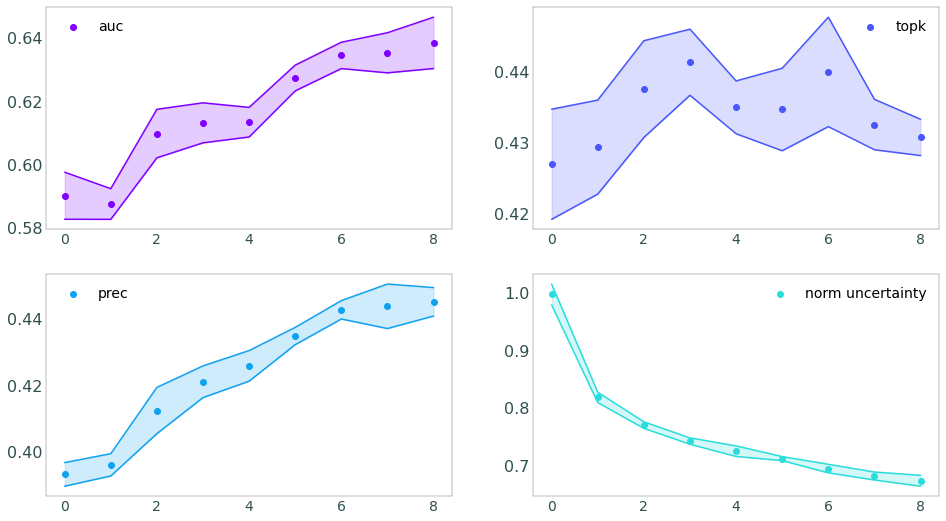

In [46]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import cm
fig, axs = plt.subplots(2, 2 )
fig.set_figheight(9)
fig.set_figwidth(16)


def cm2inch(value):
        return value/2.54

small = 14
med = 16
large = 18

plt.style.use('seaborn-white')
COLOR = 'black'
params1 = {'axes.titlesize': small,
            'legend.fontsize': small,
            'axes.labelsize': med,
            'axes.titlesize': small,
            'xtick.labelsize': med,
            'ytick.labelsize': med,
            'figure.titlesize': med, 
            'font.family': "sans-serif",
            'font.sans-serif': "Myriad Hebrew",
            'text.color' : COLOR,
            'axes.labelcolor' : COLOR,
            'axes.linewidth' : 1,
            'xtick.color' : COLOR,
            'ytick.color' : COLOR}

plt.rcParams.update(params1)
plt.rc('text', usetex = False)



color = iter(cm.rainbow(np.linspace(0, 1, 10)))
c = next(color)
x = np.arange(9)
y = mean__auc_[1:]
err = std__auc_[1:]
axs[0,0].scatter(x, y, color=c, label = 'auc')
axs[0,0].fill_between(x, y-err, y+err, color=c, alpha= 0.2)
axs[0,0].plot(x, y-err, color=c)
axs[0,0].plot(x, y+err, color=c)


c = next(color)
x = np.arange(9)
y = mean__topk_[1:]
err = std__topk_[1:]
axs[0,1].scatter(x, y, color=c, label = 'topk')
axs[0,1].fill_between(x, y-err, y+err, color=c, alpha= 0.2)
axs[0,1].plot(x, y-err, color=c)
axs[0,1].plot(x, y+err, color=c)


c = next(color)
x = np.arange(9)
y = mean__prec_[1:]
err = std__prec_[1:]
axs[1,0].scatter(x, y, color=c, label = 'prec')
axs[1,0].fill_between(x, y-err, y+err, color=c, alpha= 0.2)
axs[1,0].plot(x, y-err, color=c)
axs[1,0].plot(x, y+err, color=c)

c = next(color)
x = np.arange(9)
y = mean__loss_[1:]
err = std__loss_[1:]
axs[1,1].scatter(x, y, color=c, label = 'norm uncertainty')
axs[1,1].fill_between(x, y-err, y+err, color=c, alpha= 0.2)
axs[1,1].plot(x, y-err, color=c)
axs[1,1].plot(x, y+err, color=c)

axs[0,0].legend()
axs[1,0].legend()
axs[0,1].legend()
axs[1,1].legend()
plt.show()